# Seminar 5

# Intro to Numerical Optimization. Gradient Descent.

In [1]:
import time
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
np.__version__, matplotlib.__version__

('1.18.3', '3.0.3')

In [4]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

# 1. Intro to Numerical Optimization

$$\min_{x\in\mathbb{R}^n} f(x) + \lambda \|x-x_0\|^2$$

Большинство методов итеративные и имеют вид:

$$x_k = x_{k-1}+\alpha_k h_k$$

## 1.1. Start Point

1. Случайная инициализация

2. Оценить область, где может находиться $x$ и взять центр этой области

3. Если вы можете решите упрощенную версию исходной задачи оптимизации $\min\limits_{x\in X} f(x)$ и получить решение $\tilde{x}^*$, то можно взять $\text{proj}_X(\tilde{x}^*)$ как стартовую точку в исходной задаче.

$$f(x)\geq g(\lambda, \nu)$$

## 1.2. Stop Rule

**Цель: Найти $x$ такой, что $f(x)-f^*\leq \varepsilon$**

Критерии, которые гарантируют, что Вы нашли $\varepsilon$-решение:

Duality Gap: $f(x_k) - g(\lambda, \nu)\leq \varepsilon \Rightarrow f(x)-f^*\leq \varepsilon$

Критерии без гарантии:

1. $|f_k - f_{k-1}| \leq \varepsilon$

2. $\|x_k - x_{k-1}\| \leq \varepsilon$

3. $\|\nabla f(x_k)\|\leq \varepsilon$

## 1.3. Step Size

1. Constant Step Size $\alpha_k=\alpha_0 \leq \frac{1}{L}$

2. Убывающая последоватльность: $\alpha_k = \alpha(k)$. Например, $\alpha_k=\frac{1}{k}$.

Есди $h_k$ это направление убывания (т.е. $\exists \alpha_0\forall \alpha<\alpha_0 f(x+\alpha h)\leq f(x)$), то можно воспользоваться следующими правилами.

1. Наискорейший спуск: $\alpha_k = \arg\min\limits_{\alpha_k \geq 0} f(x_k+\alpha_k h_k)$ 

    * Достаточное убывание: $f(x_{k+1}) \leq f(x_k) + \beta_1 \alpha_k \langle f'(x_k), h_k \rangle$
    * Существенное убывание: $f(x_{k+1}) \geq f(x_k) + \beta_2 \alpha_k \langle f'(x_k), h_k \rangle$
    * Условие кривизны: $\langle f'(x_{k+1}), h_k \rangle \geq \beta_2 \langle f'(x_k), h_k \rangle$

2. Правило Армихо: Достаточное убывание

3. Правило Вольфа: Достаточное убывание + Условие Кривизны

4. Правило Гольдштейна: Достаточное убывание + Существенное убывание

In [5]:
class StepSize:
    def __call__(self, x, h, k, *args, **kwargs):
        pass

In [6]:
class ConstantStepSize(StepSize):
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha

In [7]:
class SeqStepSize(StepSize):
    def __init__(self, d=1, alpha0=1, alpha_function=None):
        if alpha_function is not None:
            self.alpha_function = alpha_function
        else:
            self.alpha_function = lambda k: alpha0/(k+1)**d
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha_function(k)

In [20]:
class Armijo(StepSize):
    def __init__(self, beta=0.3, rho=0.5, alpha0=1):
        self.beta = beta
        self.rho = rho
        self.alpha0 = alpha0
    
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        beta, rho, alpha = self.beta, self.rho, self.alpha0
        fx = f(x)
        gx = gradf(x)
        gxh = gx.dot(h)
        while f(x + alpha * h) > fx + beta * alpha * gxh:
            # Уменьшить alpha
            alpha *= rho
        return alpha

 $$\alpha_k = \arg\min\limits_{\alpha_k \geq 0} f(x_k+\alpha_k h_k)$$
 
 $$\alpha_k = \arg\min\limits_{\alpha \geq 0} \frac{1}{2}(x_k+\alpha h_k)^\top A (x_k+\alpha h_k) + b^\top (x_k+\alpha h_k) $$

In [ ]:
class QPfastest(StepSize):
    def __init__(self, A, b):
        self.A = A
        self.b = b
    
    def __call__(self, x, h, k, *args, **kwargs):
        # YOUR CODE HERE
        pass

## 1.4. Direction Choice

Простейший метод - **Gradient Descent**

$$x_k = x_{k-1}-\alpha_k \nabla f(x_k)$$

In [9]:
class GradientDescent:
    def __init__(self, StepSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []
    
    def __call__(self, x0, f, gradf, N):
        self.history = [(x0, time.time())]
        x = x0.copy()
        for k in range(N):
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x = x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
        return x
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        x_prev = None
        while x_prev is None or abs(f(x_prev) - f(x)) > tol: 
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x_prev, x = x, x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x

In [10]:
def parse_logs(xhistory, ret_time=False, funcx=None):
    values = [funcx(x) for x, _ in xhistory]
    if ret_time:
        times = [t for _, t in xhistory]
        times = [0] + [times[ind+1]-t for ind, t in enumerate(times[:-1])]
    else:
        times = [i for i in range(len(xhistory))]
    return times, values

## 2. Gradient Descent

### 2.1. Quadratic programming

$$\min_{x \in \mathbb{R}^n} \frac{1}{2}x^\top A x + b^\top x$$

$A\in\mathbb{S}^n_+, b\in\mathbb{R}^n$

#### n = 10

In [12]:
np.random.seed(1)
n = 10
A = np.random.randn(n, n)
A = A.T @ A + 1e-1 * np.eye(n)
b = np.random.randn(n)
f = lambda x: 1/2 * x.T @ A @ x + b.T @ x
gradf = lambda x: A @ x + b

In [13]:
x0 = np.zeros(n)
N = 1000

In [14]:
# Lipschitz Constant of Gradient f
L = np.linalg.eigvals(A).max()
L

23.135557228796564

In [29]:
methods = [GradientDescent(ConstantStepSize(1 / L), name="GD, 1/L"),
           GradientDescent(SeqStepSize(d=1), name="GD, 1/k"),
           GradientDescent(SeqStepSize(alpha_function=lambda k: min(1e-1, 1/(k+1)**(1/2))), name=r"GD, $1/k^2$"),
           GradientDescent(Armijo(), name=r"GD, Armijo"),
          ]

In [30]:
for method in methods:
    method(x0, f, gradf, N)

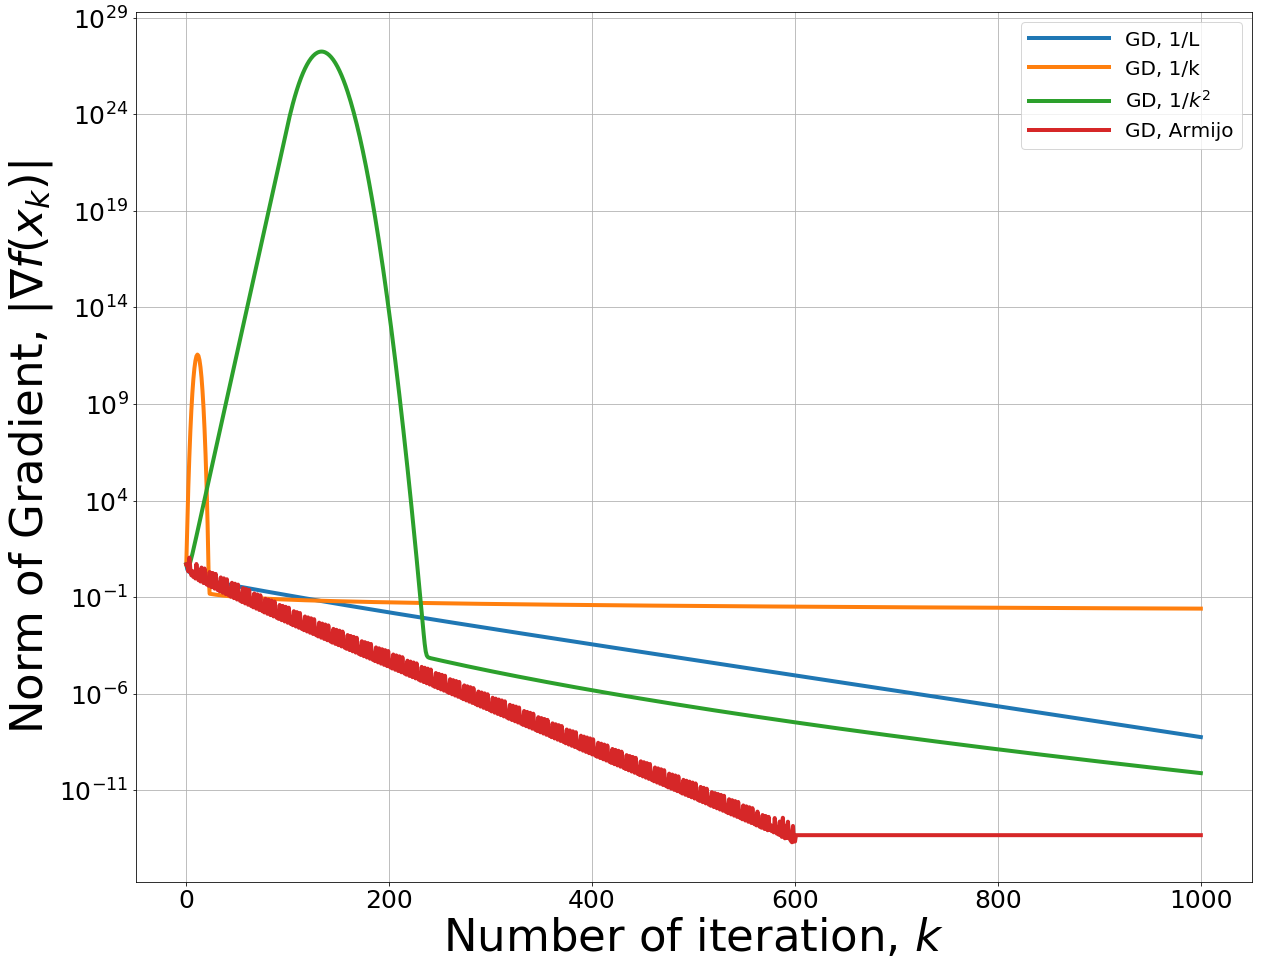

In [31]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))**2
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $\|\nabla f(x_k)\|$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

In [19]:
funcx = lambda x: None
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=True, funcx=funcx)
    print("{}\t\t{:.2f} ms".format(method.name, 1000* times[-1]))

GD, 1/L		0.01 ms
GD, 1/k		0.01 ms
GD, $1/k^2$		0.01 ms
GD, Armijo		0.34 ms


## n = 100

In [36]:
np.random.seed(1)
n = 100
A = np.random.randn(n, n)
A = A.T @ A + 1e-1 * np.eye(n)
b = np.random.randn(n)
f = lambda x: 1/2 * x.T @ A @ x + b.T @ x
gradf = lambda x: A @ x + b

x0 = np.zeros(n)
N = 10000
L = max(np.linalg.eigvals(A))

In [37]:
methods = [GradientDescent(ConstantStepSize(1 / L), name="GD, 1/L"),
           GradientDescent(Armijo(), name=r"GD, Armijo"),
          ]
for method in methods:
    method(x0, f, gradf, N)

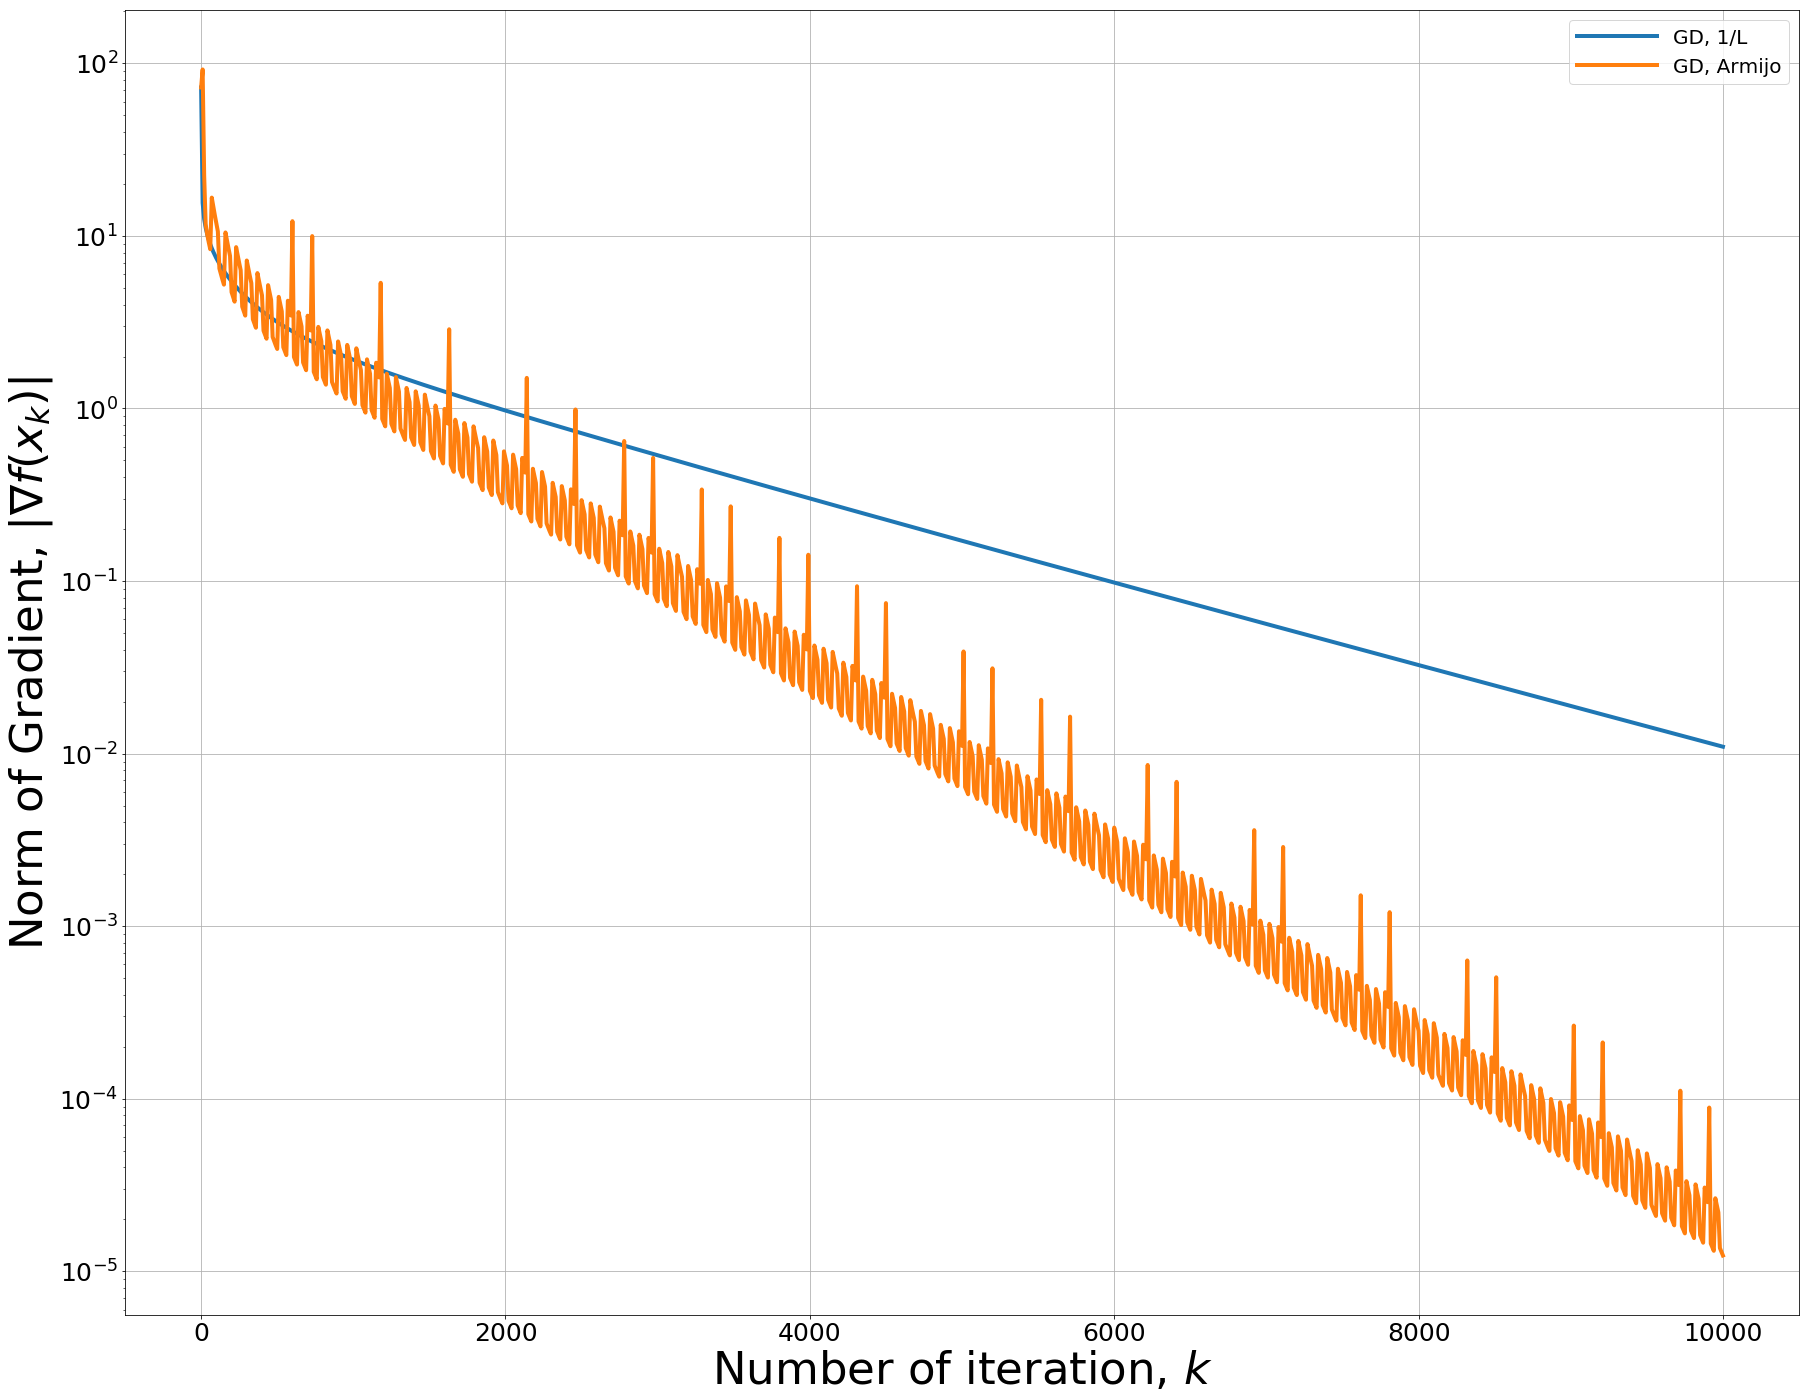

In [38]:
%matplotlib inline
plt.figure(figsize=(30, 24))
funcx = lambda x: np.linalg.norm(gradf(x))**2
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times[::10], values[::10], label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $\|\nabla f(x_k)\|$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

### 2.2. Conditional Number

$$\min_{x \in \mathbb{R}^n} \frac{1}{2}x^\top A x$$

$$\kappa=\frac{L}{\mu}=\frac{\lambda_{\max}}{\lambda_{\min}}$$

In [41]:
gamma = 10**3
A = np.diag([gamma, 1])

## 3. Autodiff. Jax

In [ ]:
#!pip install --upgrade "jax[cpu]"

In [42]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

### 3.1. Calculations Acceleration

In [43]:
def get_data(n, m):
    x = jax.random.normal(jax.random.PRNGKey(0), (n, ))
    A = jax.random.normal(jax.random.PRNGKey(0), (m, n))
    b = jax.random.normal(jax.random.PRNGKey(0), (m, ))
    return x, A, b

In [44]:
def f1(x, A, b):
    '''
    f(x) = ||Ax-b||^2
    '''
    res = A @ x - b
    return res @ res

In [45]:
@jax.jit
def f(x, A, b):
    '''
    f(x) = ||Ax-b||^2
    '''
    res = A @ x - b
    return res @ res

In [46]:
x, A, b = get_data(1000, 1000)
%timeit f1(x, A, b)
%timeit f(x, A, b)

578 µs ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
551 µs ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### 3.2. Gradient Calculation

In [47]:
n = 1000
x, A, b = get_data(n, n)

In [48]:
gradf = jax.grad(f, argnums=0, has_aux=False)
grad_analytic = lambda x, A, b: 2 * A.T @ (A @ x - b)

In [49]:
print("Check correctness", jnp.linalg.norm(gradf(x, A, b) - 2 * A.T @ (A @ x - b)))
print("Compare speed")
print("Analytical gradient")
%timeit grad_analytic(x, A, b)
print("Grad function")
%timeit gradf(x, A, b).block_until_ready()
jit_gradf = jax.jit(gradf)
print("Jitted grad function")
%timeit jit_gradf(x, A, b).block_until_ready()

Check correctness 8.944556828777878e-11
Compare speed
Analytical gradient
6.03 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Grad function
4.44 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Jitted grad function
1.2 ms ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### 3.3. Hessian Calculation

In [50]:
hessian_analytic = lambda x, A, b: 2 * A.T @ A

In [51]:
hess_func = jax.jit(jax.hessian(f))

print("Check correctness", jnp.linalg.norm(hessian_analytic(x, A, b) - hess_func(x, A, b)))

print("Time for analytical hessian")
%timeit hessian_analytic(x, A, b)
print("Time for hessian")
%timeit hess_func(x, A, b).block_until_ready()

Check correctness 0.0
Time for analytical hessian
39.3 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time for hessian
89.3 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 3.4. Jacobian Calculation

$$g(y) = \frac{\exp(y)}{\sum\limits_{i=1}^n \exp(y_i)}$$

$$f(x)= g(Ax+b)$$

$$F = f_1(f_2(f_3...f_n(x))))$$

$$J(F) = J(f_1) J(f_2) \dots J(f_n)$$

$$J(F) = J(f_1) (J(f_2)( \dots J(f_n))) - \text{forward propagation}$$ 

$$J(F) = ((J(f_1) J(f_2)) \dots J(f_n))) - \text{backward propagation}$$

In [66]:
def fvec(x, A, b):
    # f: R^n -> R^m
    y = A @ x + b
    a = jnp.max(y)
    return jnp.exp(y - a) / jnp.sum(jnp.exp(y - a))

In [64]:
x, A, b = get_data(10, 10)
value = fvec(1e9 * x, A, b)
value, sum(value)

(DeviceArray([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float64), 1.0)

In [65]:
fmode_fvec = jax.jit(jax.jacfwd(fvec))
bmode_fvec = jax.jit(jax.jacrev(fvec))

#### 3.4.1 Case $m \ll n$

In [67]:
n = 1000

In [68]:
x, A, b = get_data(n, n//10)
print("Check correctness", jnp.linalg.norm(fmode_fvec(x, A, b) - bmode_fvec(x, A, b)))
print("Check shape", fmode_fvec(x, A, b).shape, bmode_fvec(x, A, b).shape)
print("Time forward mode")
%timeit fmode_fvec(x, A, b).block_until_ready()
print("Time backward mode")
%timeit bmode_fvec(x, A, b).block_until_ready()

Check correctness 1.572787519716566e-15
Check shape (100, 1000) (100, 1000)
Time forward mode
6.37 ms ± 445 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Time backward mode
808 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### 3.4.2. Case $m \geq n$

In [69]:
x, A, b = get_data(n, n)
print("Check correctness", jnp.linalg.norm(fmode_fvec(x, A, b) - bmode_fvec(x, A, b)))
print("Check shape", fmode_fvec(x, A, b).shape, bmode_fvec(x, A, b).shape)
print("Time forward mode")
%timeit fmode_fvec(x, A, b).block_until_ready()
print("Time backward mode")
%timeit bmode_fvec(x, A, b).block_until_ready()

Check correctness 7.940999414400821e-16
Check shape (1000, 1000) (1000, 1000)
Time forward mode
47.1 ms ± 772 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time backward mode
52.6 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [70]:
x, A, b = get_data(n, n*10)
print("Check correctness", jnp.linalg.norm(fmode_fvec(x, A, b) - bmode_fvec(x, A, b)))
print("Check shape", fmode_fvec(x, A, b).shape, bmode_fvec(x, A, b).shape)
print("Time forward mode")
%timeit fmode_fvec(x, A, b).block_until_ready()
print("Time backward mode")
%timeit bmode_fvec(x, A, b).block_until_ready()

Check correctness 7.437998502450645e-21
Check shape (10000, 1000) (10000, 1000)
Time forward mode
632 ms ± 37.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time backward mode
4.79 s ± 94.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 3.4.3. Common Case

In [73]:
n = 1000
fmode_time = []
bmode_time = []
m_list = [10, 50, 100, 500, 1000, 2000, 5000, 10000]
for m in m_list:
    x, A, b = get_data(n, m)
    t0 = time.time()
    fmode_fvec(x, A, b).block_until_ready()
    t1 = time.time()
    bmode_fvec(x, A, b).block_until_ready()
    t2 = time.time()
    fmode_time.append(t1-t0)
    bmode_time.append(t2-t1)

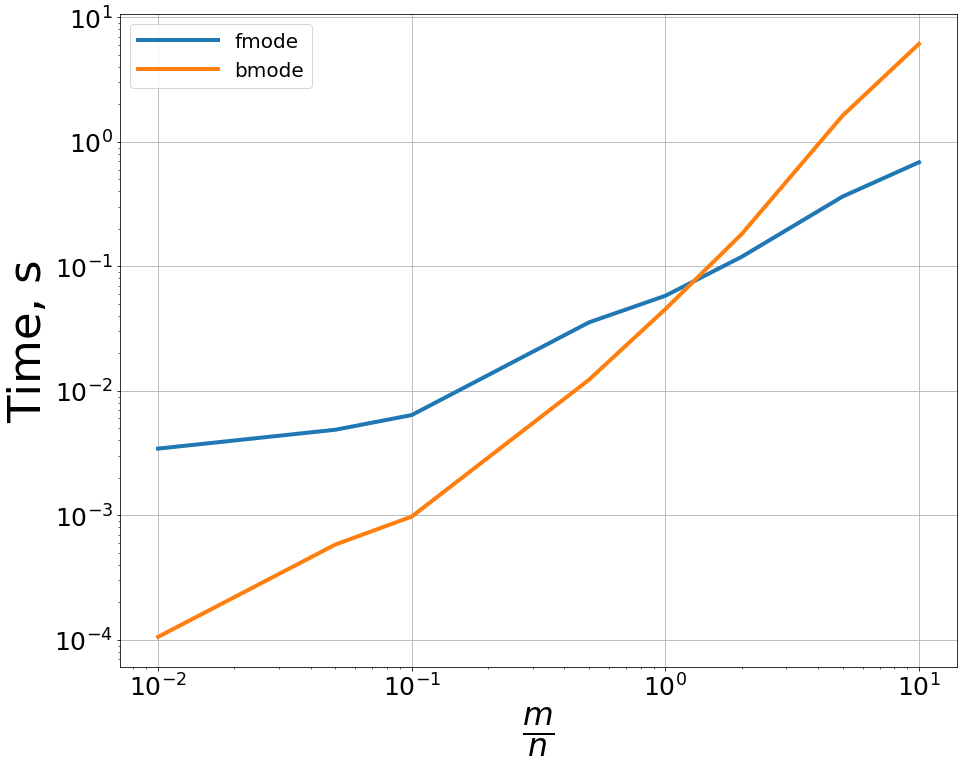

In [74]:
%matplotlib inline
plt.figure(figsize=(15,12))
mn_list = [m / n for m in m_list]
plt.plot(mn_list, fmode_time, label="fmode")
plt.plot(mn_list, bmode_time, label="bmode")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\frac{m}{n}$")
plt.ylabel("Time, s")
plt.grid()

## Summary

...